# 🍏🍌🍊 **Fruit Freshness Detection – Computer Vision Project**

![](https://i.postimg.cc/tCz5Zkhm/image-title.png)

---

## 📄 **Project Overview**

This project aims to build a deep learning model that classifies images of fruits as **fresh** or **rotten** using computer vision techniques. The model is trained to identify features like color changes, texture differences, and signs of decay across images of **apples**, **bananas**, and **oranges**.

I used **transfer learning** with the pre-trained **VGG16** model to improve performance and reduce training time. The dataset is sourced from Kaggle and includes labeled images for six categories

## 🎯 **Objectives**

- 🏷️ Classify fruits as **Fresh** or **Rotten**
- 🧠 Train a CNN using labeled fruit images
- 🖼️ Preprocess and normalize image data
- 📊 Evaluate model performance using classification metrics and visualization
- 🧪 Visualize sample predictions using images and model outputs

---

## 🔧 **Tools and Libraries**

- 🐍 Python
- 🧠 TensorFlow / Keras – for CNN and transfer learning
- 🖼️ OpenCV – for image loading and preprocessing
- 📊 Matplotlib – for evaluation visualization
- 📁 Kaggle Dataset – 'Fruits Fresh and Rotten for Classification'




In [55]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import random
import os

In [57]:
import tensorflow as tf

print("TF version:", tf.__version__)

TF version: 2.17.1
Hub version: 0.16.1


## 🌱**Data Preprocessing and Loading** 
Before training a deep learning model, it is essential to preprocess the dataset to improve generalization and ensure the model learns meaningful patterns. This section covers rescaling, and loading the images into the model.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define paths
train_dir = "/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train"
test_dir = "/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test"

In [59]:
import os


# Get the list of subdirectories (representing classes)
classes = os.listdir(train_dir)

# Count the number of samples in each class
class_counts = {}

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # Check if it's a directory (class)
        class_counts[class_name] = len(os.listdir(class_path))

# Display the class counts
for class_name, count in class_counts.items():
    print(f"Train Class: {class_name}, Number of Samples: {count}")

test_class_counts = {}

for class_name in classes:
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):  # Check if it's a directory (class)
        test_class_counts[class_name] = len(os.listdir(class_path))

# Display the test class counts
for class_name, count in test_class_counts.items():
    print(f" Test Class: {class_name}, Number of Samples: {count}")


Train Class: rottenbanana, Number of Samples: 2224
Train Class: freshoranges, Number of Samples: 1466
Train Class: rottenoranges, Number of Samples: 1595
Train Class: freshbanana, Number of Samples: 1581
Train Class: rottenapples, Number of Samples: 2342
Train Class: freshapples, Number of Samples: 1693
 Test Class: rottenbanana, Number of Samples: 530
 Test Class: freshoranges, Number of Samples: 388
 Test Class: rottenoranges, Number of Samples: 403
 Test Class: freshbanana, Number of Samples: 381
 Test Class: rottenapples, Number of Samples: 601
 Test Class: freshapples, Number of Samples: 395


### 1️⃣ Rescaling Test and Data Augmentation

Before training the model, we need to preprocess the images to make them suitable for the neural network.
- **Rescaling**: All pixel values are scaled to the `[0, 1]` range by dividing by 255. This helps the model learn more efficiently.
- **Data Augmentation** (for training data only): We apply random transformations like:
Augmentation helps the model generalize better and prevents overfitting, especially when the dataset isn't very large.

The test data is **only rescaled** (no augmentation), to ensure we evaluate on clean, unaltered images.

In [9]:
# Rescale test&train images 
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,  # Use 20% for validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


### 2️⃣ Load Training and Testing Data
Using the `flow_from_directory` method, we load the training and testing images from specified directory. The images are resized to 224x224 pixels, and the batch size is set to 32, the `class_mode` is set to 'categorical', meaning the labels are one-hot encoded.

In [10]:
# Create the training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,                  # Path to training images directory
    target_size=(224, 224),     # Resize all images to 224x224 (required by VGG16)
    batch_size=32,              # Number of images per batch
    class_mode='categorical',   # Use categorical labels (one-hot encoded)
    subset='training',          # Use this for training (not validation split)
    shuffle=True,               # Shuffle the images for better training
    seed=42                     # Set random seed for reproducibility
)

#  Create the validation data generator (split from training data)
val_generator = train_datagen.flow_from_directory(
    train_dir,                  # Use the same training directory
    target_size=(224, 224),     
    batch_size=32,
    class_mode='categorical',
    subset='validation',        
    shuffle=True,
    seed=42
)

#  Create the test data generator (used for final evaluation)
test_generator = test_datagen.flow_from_directory(
    test_dir,                   
    target_size=(224, 224),     
    batch_size=32,
    shuffle=False,              # Do NOT shuffle to preserve label order during prediction
    class_mode='categorical'    # Use categorical labels
)


Found 9813 images belonging to 6 classes.
Found 1088 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


## 🖼️ **Loading and Displaying Images**

In this section, we load images of fruits and define a custom function to display them. Additionally, we create a function that selects a random subset of images from a specified folder and loads them into a list. This approach allows us to visualize different samples of fresh and rotten fruits, helping us better understand the dataset.

- First, we load the images of various fruits (apples, bananas, and oranges).
- Then, we define a function to randomly select images from each category and display them.

In [62]:
def image_show(image_list, title=None, rows=1, cols=1):
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
    
    if rows == 1:
        axes = [axes]  # Ensure axes is always iterable
    
    for i, (image, ax) in enumerate(zip(image_list, np.ravel(axes))):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        ax.imshow(image)
        ax.axis("off")  # Hide axis 
    fig.suptitle(title, fontsize=16, y=1.05)  
        
    plt.tight_layout()
    plt.show()

In [63]:
def select_random_images_from_folder(folder_path, image_num):
    """
    Selects a random subset of images from a specified folder and loads them into a list.
    """

    # List all files in the folder
    image_files = os.listdir(folder_path)
       
    # Randomly select images from the list of image files
    selected_images = random.sample(image_files, image_num)
    
    image_list = []
    
    # Load the selected images into the list
    for image_name in selected_images:
        image_path = os.path.join(folder_path, image_name)
        image = cv2.imread(image_path)  # Read the image from the file
        image_list.append(image)
                           
    return image_list

### 📸 **Visualizing 10 Random Images from the Training Data**

 We will randomly select and visualize 10 images from our training data, which includes fresh and rotten bananas, oranges, and apples. We'll use the `select_random_images_from_folder` function to randomly pick images from the different classes and the `image_show` function to display them.

We will show a subset of images from the following classes:
- 🍏 Fresh Apples
- 🍎 Rotten Apples
- 🍌 Fresh Bananas
- 🍌 Rotten Bananas
- 🍊 Fresh Oranges
- 🍊 Rotten Oranges

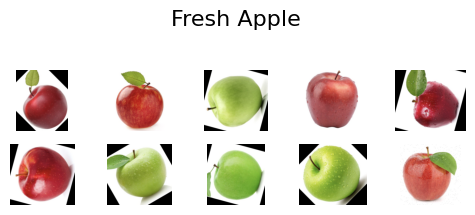

In [64]:
freshapples = select_random_images_from_folder("/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/freshapples/", 10)
image_show(freshapples, title='Fresh Apple', rows=2, cols=5)

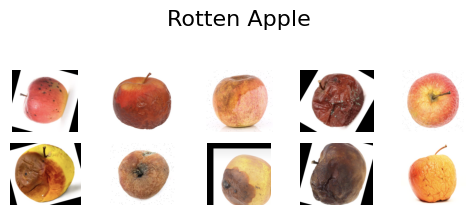

In [65]:
rottenapples = select_random_images_from_folder("/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/rottenapples/", 10)
image_show(rottenapples, title='Rotten Apple', rows=2, cols=5)

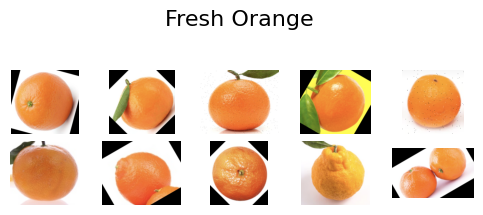

In [66]:
freshoranges = select_random_images_from_folder("/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/freshoranges/", 10)
image_show(freshoranges, title='Fresh Orange', rows=2, cols=5)

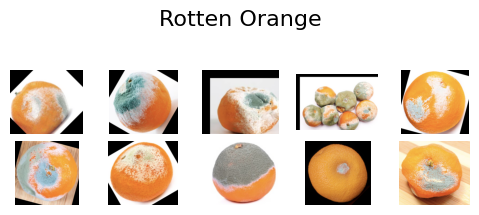

In [67]:
rottenoranges = select_random_images_from_folder("/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/rottenoranges/", 10)
image_show(rottenoranges, title='Rotten Orange', rows=2, cols=5)

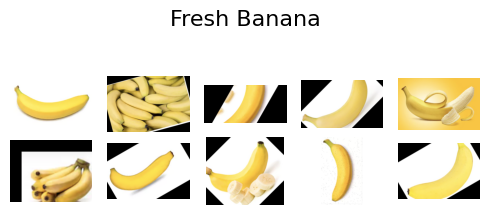

In [68]:
freshbanana = select_random_images_from_folder("/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/freshbanana/", 10)
image_show(freshbanana, title='Fresh Banana', rows=2, cols=5)

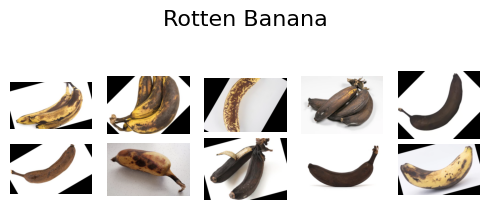

In [69]:
rottenbanana = select_random_images_from_folder("/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/rottenbanana/", 10)
image_show(rottenbanana, title='Rotten Banana', rows=2, cols=5)

## 🍏 **Fruit Freshness Detection Model Using VGG16** 🍎
In this section, we are building a **deep learning model** that can classify **fresh and rotten fruits** based on images. 🥑🍊  

To achieve this, we use **VGG16**, a powerful pre-trained deep learning model, and fine-tune it with our dataset. By leveraging **transfer learning**, we can use knowledge from large-scale image datasets to improve our classification accuracy.  

### ✅ **Goals**  
✔️ Build a **deep learning model** for fruit freshness detection.  
✔️ Use **VGG16** for feature extraction.  
✔️ Fine-tune the model to **classify fresh vs. rotten fruits**.  
✔️ Evaluate model performance on test images.  

<details>
  <summary><strong>📌 Click here to learn more about VGG16<strong></summary>

### 🖼️ What is VGG16?  
VGG16 is a deep convolutional neural network (CNN) that was developed by the **Visual Geometry Group (VGG)** at the University of Oxford. It is widely used in image classification tasks due to its **simple yet effective** architecture.

### 🔑 Key Features of VGG16:
- **Architecture:** Consists of **16 layers** (13 convolutional layers + 3 fully connected layers).  
- **Small Filters:** Uses **3x3 convolution filters**, making it better at capturing fine image details.  
- **Pooling:** Uses **max pooling layers** to reduce image size while keeping important features.  
- **Pre-Trained Weights:** Trained on **ImageNet**, making it great for transfer learning.  

### 🛠️ How VGG16 Works:
1️⃣ **Extracts Features** → First layers detect simple patterns like edges.  
2️⃣ **Builds Complexity** → Deeper layers detect textures, shapes, and objects.  
3️⃣ **Classifies Objects** → Fully connected layers decide the final category.  

VGG16 is a powerful **feature extractor**, and we use transfer learning to adapt it for our fruit freshness detection task! 🍏🍌🍎  

</details>

In [71]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model 


### **Loading the Pre-trained VGG16 Model**

We load the VGG16 model pre-trained on ImageNet. We exclude the top classification layers because we will be adding our own custom layers for fruit classification. The input shape for images is set to `(224, 224, 3)`.

- `weights`: We specify the pre-trained weights.
- `include_top`: Set to `False` to exclude the top classification layers.

In [83]:
base_model = VGG16(weights='/kaggle/input/vgg16/tensorflow2/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224,224,3))

### **Freezing Base Model Layers**

We freeze the base model's layers so that their weights will not be updated during training. This is important to leverage the pre-trained features and avoid overfitting on small datasets.

In [84]:
base_model.trainable = False

###  **Adding Custom Layers to VGG16**

Since VGG16 is a **pre-trained model**, we need to modify its architecture by adding custom layers to adapt it to our **fruit freshness classification task**.  

 ✅ **Why Do We Need Custom Layers?**
- The original VGG16 model is designed for **1,000 classes** in ImageNet, but our dataset has **only 6 classes** (fresh/rotten for 3 fruits).  
- By adding **fully connected layers**, we allow the model to learn **task-specific features**.  
- We **freeze** the original VGG16 layers so they act as a **feature extractor** while training only our custom layers.  

---

## 🔹 **Custom Layers Added to the Model**

| **Layer Name** | **Purpose** | **Details** |
|--------------|------------|------------|
| **GlobalAveragePooling2D** | Reduces dimensionality while retaining important features | Converts feature maps into a single vector |
| **Dense Layer (FC1)** | Feature extraction | 1024 neurons, **ReLU activation** |
| **Dropout** | Prevents overfitting | 50% dropout rate |
| **Output Layer** | Final classification layer | 6 neurons, **Softmax activation** |

In [85]:
x = base_model.output  # get the output of the last layer  
x = GlobalAveragePooling2D()(x)  # apply global average pooling   
x = Dense(1024, activation='relu')(x)  # add a fully connected (dense) layer  
predictions = Dense(6, activation='softmax')(x)  # add the final output layer  

# create a new model that takes the base model's input and produces our custom output  
model = Model(inputs=base_model.input, outputs=predictions)

###  **Compiling the Model** 

We compile the model using the **Adam optimizer**, which is widely used for training deep learning models due to its adaptability and efficiency.  

- The **loss function** used is **categorical cross-entropy**, as we are dealing with a **multi-class classification** problem.  
- We also track the **accuracy** metric during training to evaluate the model's performance.

In [87]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## 🚀 **Training the Model**  

To train our fruit freshness detection model, we use the **fit()** function, which iterates through the dataset and updates the model’s weights.  

- **`train_data`**: The dataset used for training.  
- **`steps_per_epoch=100`**: Defines how many batches of training data the model processes per epoch.  
- **`epochs=10`**: The number of times the model will go through the entire dataset during training.

In [114]:
print(f"Train samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")


Train samples: 9813
Validation samples: 1088


In [115]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)


Epoch 1/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 154s 493ms/step - accuracy: 0.9293 - loss: 0.2022 - val_accuracy: 0.9375 - val_loss: 0.1659
Epoch 2/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 42us/step - accuracy: 0.9375 - loss: 0.2156  
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


306/306 ━━━━━━━━━━━━━━━━━━━━ 152s 486ms/step - accuracy: 0.9318 - loss: 0.1773 - val_accuracy: 0.9550 - val_loss: 0.1211
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 47us/step - accuracy: 1.0000 - loss: 0.0535  
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 154s 491ms/step - accuracy: 0.9408 - loss: 0.1609 - val_accuracy: 0.9375 - val_loss: 0.1704
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 47us/step - accuracy: 1.0000 - loss: 0.0332  
Epoch 7/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 151s 484ms/step - accuracy: 0.9400 - loss: 0.1659 - val_accuracy: 0.9485 - val_loss: 0.1325
Epoch 8/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 35us/step - accuracy: 0.9062 - loss: 0.2970  
Epoch 9/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 147s 472ms/step - accuracy: 0.9436 - loss: 0.1511 - val_accuracy: 0.9550 - val_loss: 0.1031
Epoch 10/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 46us/step - accuracy: 0.9688 - loss: 0.0651  


In [5]:
from tensorflow.keras.models import load_model

# Load the model from file
model = load_model("/kaggle/input/fruit-vision-freshness/tensorflow2/default/1/fruit_vision_model2.h5")



## 📊 **Model Evaluation and Performance Metrics** 

In this section, we will evaluate the performance of our trained model on the test dataset. We will look at key metrics like **accuracy**, **loss**, and **per-class accuracy**, as well as visualize the model’s predictions through a **confusion matrix**. These steps will give us a comprehensive understanding of how well our model is performing. 🌟

---

### 1. **Evaluating the Model on the Test Data** 🔍

Let's start by evaluating the model on the test dataset. The evaluation will return two important values: **Test Accuracy** and **Test Loss**. 

- **Test Accuracy** shows us the percentage of correct predictions the model made on the test data.
- **Test Loss** gives us an idea of how close the predicted values are to the actual labels.

In [122]:
# Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_generator)

print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.9724 - loss: 0.0867
Test Accuracy: 96.59%
Test Loss: 0.0961


### **2. Making Predictions** 🧠
Now, let's use the trained model to make predictions on the test data. The model will return probabilities for each class, but we’ll convert these probabilities into class labels.

In [123]:
# Get predictions 
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1) # Converst probabilities to class lables

# Get actual Labels
y_true = test_generator.classes

85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step


In [124]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_true, y_pred_classes)

print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9659006671608599


### **3. Understanding the Classification Report** 📑
The classification report offers a detailed breakdown of the model's performance for each class, presenting key metrics like precision, recall, and F1-score.

- **Precision** tells us the proportion of true positives out of all predicted positives.
- **Recall** shows us the proportion of true positives out of all actual positives.
- **F1-score** balances precision and recall, providing a single metric for performance.

In [125]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices))

               precision    recall  f1-score   support

  freshapples       0.97      0.96      0.97       395
  freshbanana       1.00      0.97      0.99       381
 freshoranges       0.98      0.97      0.97       388
 rottenapples       0.92      1.00      0.95       601
 rottenbanana       0.98      0.99      0.99       530
rottenoranges       0.98      0.88      0.93       403

     accuracy                           0.97      2698
    macro avg       0.97      0.96      0.97      2698
 weighted avg       0.97      0.97      0.97      2698



This report will help us assess how well the model is performing on individual classes, especially when we have an imbalanced dataset. 💡

### **4. Visualizing with a Confusion Matrix**🔄
A confusion matrix provides a more intuitive visual representation of the model’s performance. It compares the predicted labels against the true labels and highlights where the model is making errors.
The **heatmap** shows how the model’s predictions align with the true labels. The diagonal elements represent the correct predictions, and the off-diagonal elements show where the model made mistakes. The brighter the color, the higher the number of predictions in that cell. 🎨

In [11]:
test_data = test_generator

85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 429ms/step


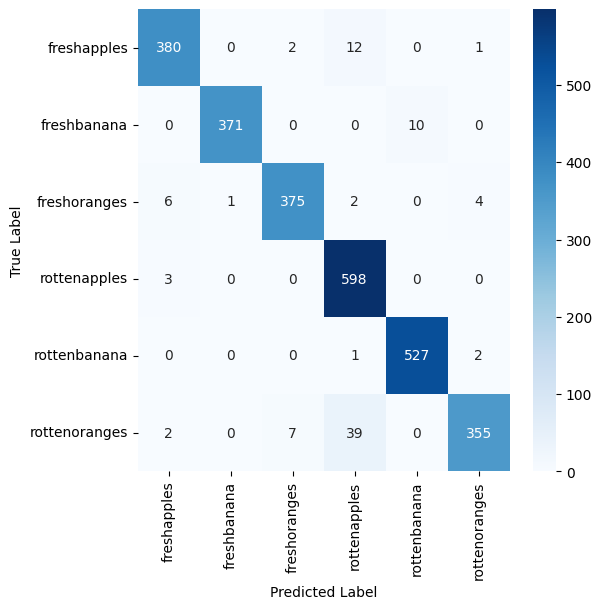

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Get predictions
y_pred = np.argmax(model.predict(test_data), axis=1)
y_true = test_data.classes  # True labels

class_names = list(test_data.class_indices.keys())  # Get class names from the test data

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 🔍**Visualizing Model Predictions on Test Images**

The following function, `show_predictions_with_titles`, displays a set of test images along with the model’s predicted class label as the title. It takes a list of image paths, runs predictions using the trained model, and shows each image in a grid format.

This helps us quickly understand how the model is performing visually — by seeing the actual output alongside the images.


In [14]:
from tensorflow.keras.preprocessing import image

def show_predictions_with_confidence(image_paths, model, class_names, rows=1, cols=1):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.5, rows * 3.5))
    
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = np.ravel(axes)
    else:
        axes = axes.flatten()

    for i, (img_path, ax) in enumerate(zip(image_paths, axes)):
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        prediction = model.predict(img_array, verbose=0)
        predicted_index = np.argmax(prediction)
        predicted_label = class_names[predicted_index]
        confidence = prediction[0][predicted_index] * 100

        # Show image
        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.set_title(f"{predicted_label}\nConfidence: {confidence:.1f}%", fontsize=9)
        ax.axis('off')

    # Hide unused subplots
    for ax in axes[len(image_paths):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [15]:
def select_random_images_from_folder(folder_path, num_images):
    # Get all image file names
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Randomly select file paths
    return random.sample(image_files, num_images)



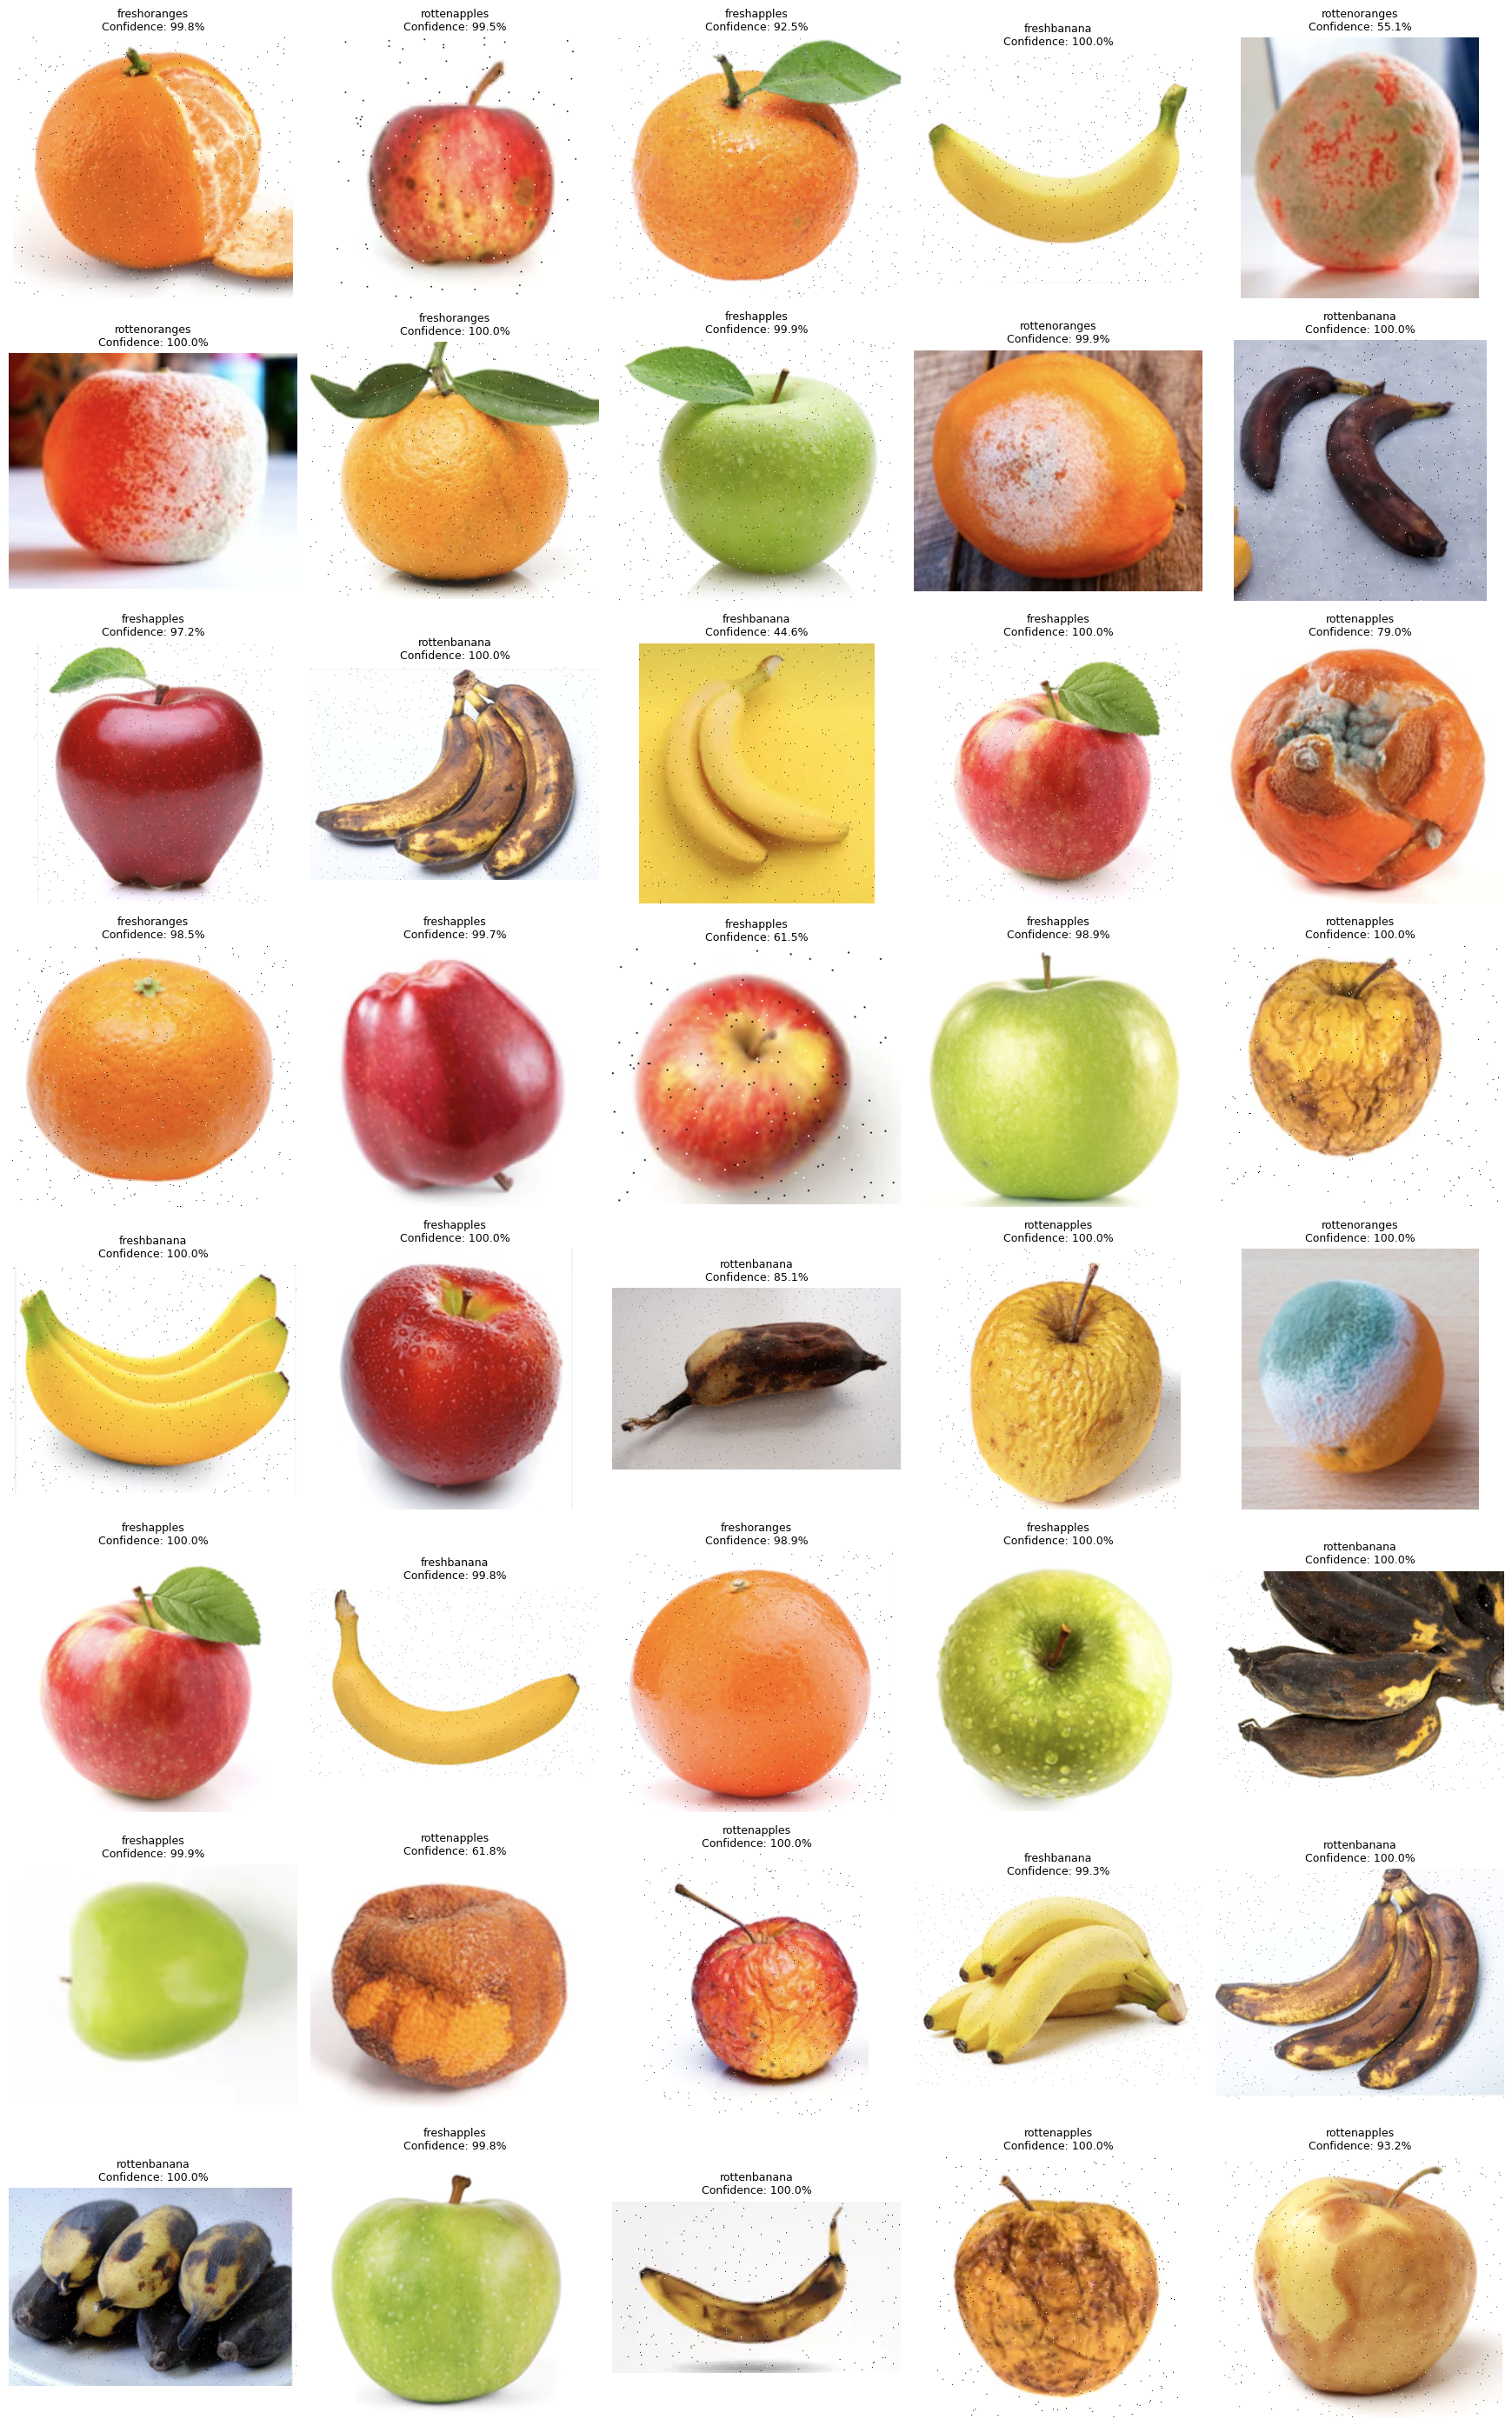

In [19]:
folder_dir = "/kaggle/input/test-data/test data"
image_list = select_random_images_from_folder(folder_dir, 40)
show_predictions_with_confidence(image_list, model, class_names, rows=8, cols=5)